In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
import keras

%load_ext autoreload
%autoreload 2
import utils

# Fetal Health Classification
Portfolio demo project, using the Fetal Health Classification data set from Kaggle. The data was taken from Cardiotocogram (CTG) readings, which measure fetal heartrate (FHR) and uterine contractions (UCs). Each sample was classified by experts as normal/1 (fetus in good health), suspect/2 (fetus may not be in good health) or pathological/3 (readings indicate fetus is not in good health). Readings were collected anywhere from 48 hours before birth and up to 30 minutes after birth.

# Feature Descriptions
|Feature Name                                          |Description                                            |
|------------------------------------------------------|-------------------------------------------------------|
|baseline value                                        |FHR baseline (beats per minute)                        |
|accelerations                                         |Number of accelerations per second                     |
|fetal_movement                                        |Number of fetal movements per second                   |
|uterine_contractions                                  |Number of uterine contractions per second              |
|light_decelerations                                   |Number of light decelerations per second               |
|severe_decelerations                                  |Number of severe decelerations per second              |
|prolongued_decelerations                              |Number of prolonged decelerations per second           |
|abnormal_short_term_variability                       |Percentage of time with abnormal short term variability|
|mean_value_of_short_term_variability                  |Mean value of short term variability                   |
|percentage_of_time_with_abnormal_long_term_variability|Percentage of time with abnormal long term variability |
|mean_value_of_long_term_variability                   |Mean value of long term variability                    |
|histogram_width                                       |Width of FHR histogram                                 |
|histogram_min                                         |Minimum (low frequency) of FHR histogram               |
|histogram_max                                         |Maximum (high frequency) of FHR histogram              |
|histogram_number_of_peaks                             |Number of histogram peaks                              |
|histogram_number_of_zeroes                            |Number of histogram zeros                              |
|histogram_mode                                        |Histogram mode                                         |
|histogram_mean                                        |Histogram mean                                         |
|histogram_median                                      |Histogram median                                       |
|histogram_variance                                    |Histogram variance                                     |
|histogram_tendency                                    |Histogram tendency                                     |

In [2]:
"""
The column names are long and unweildy, so the first thing I would like
to do is rename them to something shorter but still meaningful.
"""
df = pd.read_csv("fetal_health.csv")
print(list(df.columns.values))
cols = ["bpm","accel","movement","contractions","light_decel","severe_decel",
        "long_decel","abnormal_short_var_pct","short_var_mean","abnormal_long_var_pct",
        "long_var_mean","fhr_width","fhr_min","fhr_max","fhr_peaks","fhr_zeros",
        "fhr_mode","fhr_mean","fhr_median","fhr_var","tendency","fetal_health"]
df.columns = cols
df.to_csv("data.csv", index=False)

['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'light_decelerations', 'severe_decelerations', 'prolongued_decelerations', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'mean_value_of_long_term_variability', 'histogram_width', 'histogram_min', 'histogram_max', 'histogram_number_of_peaks', 'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean', 'histogram_median', 'histogram_variance', 'histogram_tendency', 'fetal_health']


In [3]:
"""
With the new column names, now I want to look at the class distributions,
as well as some of the metadata.
"""
df = pd.read_csv("data.csv")
print(pd.DataFrame({"count": df["fetal_health"].value_counts(), 
                    "proportion": df["fetal_health"].value_counts(normalize=True)}))

print(df.info())

              count  proportion
fetal_health                   
1.0            1655    0.778457
2.0             295    0.138758
3.0             176    0.082785
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bpm                     2126 non-null   float64
 1   accel                   2126 non-null   float64
 2   movement                2126 non-null   float64
 3   contractions            2126 non-null   float64
 4   light_decel             2126 non-null   float64
 5   severe_decel            2126 non-null   float64
 6   long_decel              2126 non-null   float64
 7   abnormal_short_var_pct  2126 non-null   float64
 8   short_var_mean          2126 non-null   float64
 9   abnormal_long_var_pct   2126 non-null   float64
 10  long_var_mean           2126 non-null   float64
 11  fhr_width               2126 non-null  

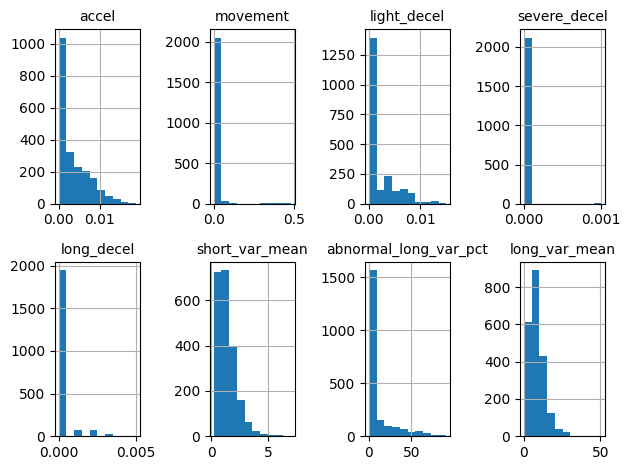

In [4]:
"""
From the output above, we can see the a large majority (77.85%) of samples
are from healthy fetuses, while only 13.88% are from suspect fetuses and
even less (8.28%) are pathological. This is expected, as most fetuses would
be in the normal range, hence why it is normal. While only a few would be
outside of that range.

When splitting our data later on, we will need to be careful with class
distribution. That is, train/validation/test sets should have similar
distributions of the class labels. We can address this later through
stratified sampling.

We can also see that all the values are floats and none of them are missing.
What we can do next is look at some distributions, and try to find any
abnormal feature distributions.
"""
df = pd.read_csv("data.csv")
# for c in df.columns.values:
#     if c == "fetal_health":
#         continue
#     utils.hist_prob_plots(df, c)
"""
After running the lines above I selected only the features with abnormalities
to display. Uncomment the top part to see all graphs.
"""
cols = ["accel","movement","light_decel","severe_decel","long_decel",
        "short_var_mean","abnormal_long_var_pct","long_var_mean"]
utils.hist_matrix(df, cols, 2, 4)


Fetal Health 1.0


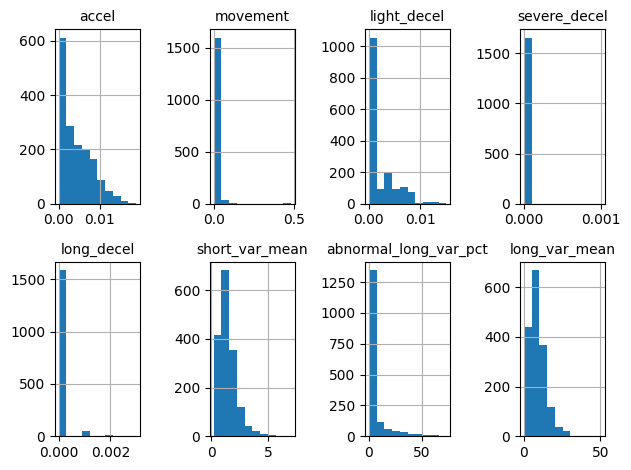

Fetal Health 2.0


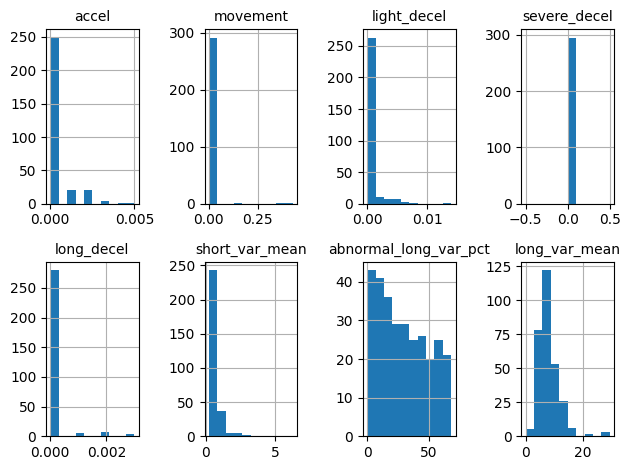

Fetal Health 3.0


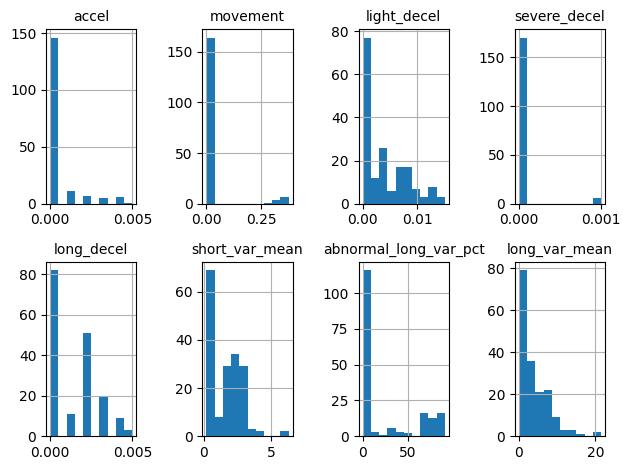

In [5]:
"""
We can see the features above are heavily right-skewed. We can take a look
at the distributions per class label, to see if there is some underlying
pattern that explains this.
"""
df = pd.read_csv("data.csv")
cols = ["accel","movement","light_decel","severe_decel","long_decel",
        "short_var_mean","abnormal_long_var_pct","long_var_mean"]
classes = [1.0,2.0,3.0]

for c in classes:
    data = df[df["fetal_health"] == c]
    print(f"Fetal Health {c}")
    utils.hist_matrix(data, cols, 2, 4)

[0.58898951 0.74991645 0.84661092 0.91694664 0.95376806 0.9821389
 0.98854751 0.99389515 0.99779216 0.99908829 0.99983207 0.99991817
 0.99997365 0.99999959 1.         1.         1.         1.
 1.         1.         1.        ]


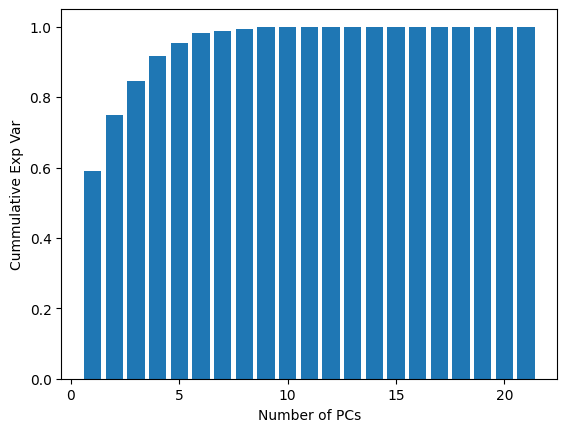

In [6]:
"""
There is maybe a pattern detected w/ accel and movement,
they seem to get more right-skewed as the fetal health
gets worse. This might indicate that less healthy fetuses
move less.

The other skewed features do not seem to exude a pattern.
We will check the PCA results to see if we can reduce our
input dimension.
"""
df = pd.read_csv("data.csv")
pca = PCA(whiten=True)
pca.fit(df[[c for c in df.columns.values if c != "fetal_health"]])
x = list(range(1,pca.n_components_+1))
print(np.cumsum(pca.explained_variance_ratio_))
_ = plt.bar(x, np.cumsum(pca.explained_variance_ratio_))
plt.ylabel("Cummulative Exp Var")
plt.xlabel("Number of PCs")
plt.show()

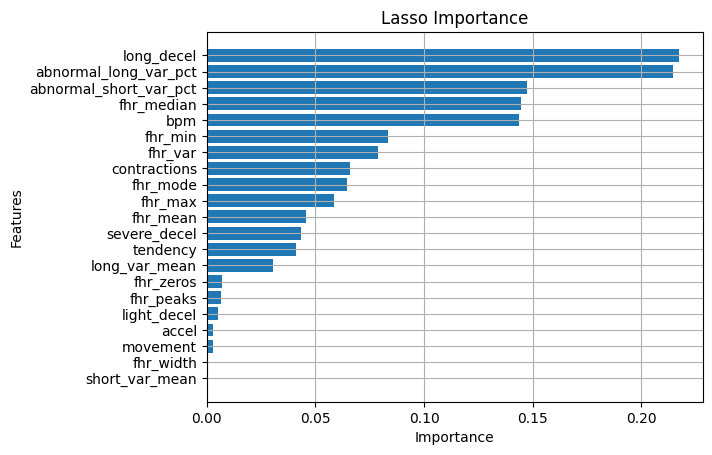

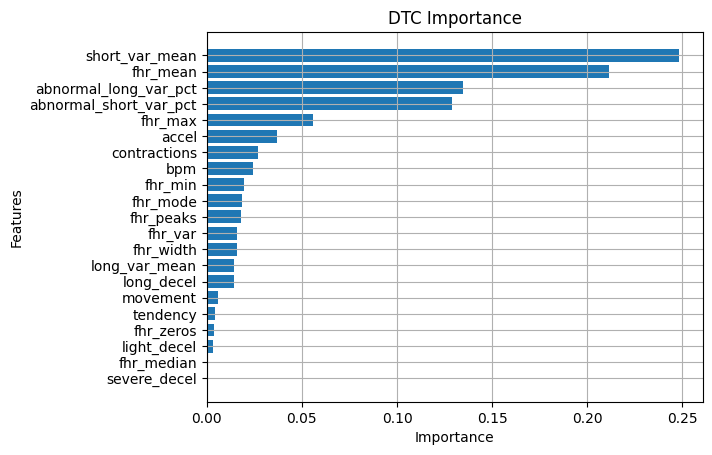

In [7]:
"""
The PCA results suggest that we can reduce our input dimension,
maybe down to 6, and still be able to explain 98% variance.

We will try a LASSO model and  DecisionTree, to see how they
weigh the feature importances. Although this is not a regression
problem, we can fit the LASSO model because the class labels
are numerical and ordinal.
"""
df = pd.read_csv("data.csv")

# LASSO feature importance
lasso = LassoCV(alphas=[0.001,0.01,0.1], n_jobs=-1, random_state=123)
x_cols = [c for c in df.columns.values if c != "fetal_health"]
idx = list(range(len(x_cols)))
df.loc[:,x_cols] = StandardScaler().fit_transform(df[x_cols])
lasso.fit(df[x_cols], df["fetal_health"])

utils.plot_feature_importance(x_cols, np.abs(lasso.coef_), title="Lasso Importance")

# DT feature importance
dtc = DecisionTreeClassifier()
dtc.fit(df[x_cols], df["fetal_health"])
utils.plot_feature_importance(x_cols, dtc.feature_importances_, title="DTC Importance")

In [8]:
"""
We can see a lot of overlap, like abnormal_long_var_pct being
highly important in both models. We can also see some contradictions
like short_var_mean being the most important for the DTC, while
also being the least importance for Lasso.

We can take a look at the top six for both models, since the PCA
suggested six dimensions in the data.
"""
lasso_top6 = [col for col, _ in sorted(zip(x_cols,np.abs(lasso.coef_)), reverse=True, key=lambda x: x[1])[:6]]
dtc_top6 = [col for col, _ in sorted(zip(x_cols,dtc.feature_importances_), reverse=True, key=lambda x: x[1])[:6]]
print(lasso_top6)
print(dtc_top6)
print(set(lasso_top6+dtc_top6))

['long_decel', 'abnormal_long_var_pct', 'abnormal_short_var_pct', 'fhr_median', 'bpm', 'fhr_min']
['short_var_mean', 'fhr_mean', 'abnormal_long_var_pct', 'abnormal_short_var_pct', 'fhr_max', 'accel']
{'fhr_median', 'bpm', 'fhr_max', 'abnormal_long_var_pct', 'long_decel', 'short_var_mean', 'fhr_min', 'accel', 'abnormal_short_var_pct', 'fhr_mean'}


In [10]:
"""
We see some overlap, but the union of the features is only 10 in length,
so for now, we will take all 10 and fit some different models to see how
well they do.

In this experiment I use a custom transformer called NonLinearTransformer
which applies combinations (sums of products) of non-linear transformations
to the input data to find linear relationships present in complex axes.
"""
def train_and_eval_classifier(model, df, x_cols, target, params=None, 
                              target_names=None, pipeline=None, trials=5, 
                              scoring="accuracy"):
    # create the column names for the report df
    rep_cols = ["Trial","Train Accuracy","Test Accuracy"]
    unique_labels = sorted(list(df[target].unique()))
    for i, val in enumerate(unique_labels):
        base = f"class({val})" if target_names is None else target_names[i]
        rep_cols.append(f"{base} Train F1")
        rep_cols.append(f"{base} Test F1")
    report = {name: [] for name in rep_cols}

    # if we are given params, assume we will do gridsearch over the params
    if params is not None:
        estimator = GridSearchCV(model, params, scoring=scoring, n_jobs=-1)
    # if params is None then assume the model is tuned and we are doing
    # cross validation
    else:
        estimator = model

    # run trials
    for j in range(trials):
        # first we split off a separate test set to use later
        x_train, x_test, y_train, y_test = train_test_split(df[x_cols], df[target], test_size=0.3, 
                                                            random_state=j, stratify=df[target])
        # run preprocessing pipeline if given
        if pipeline is not None:
            x_train[target] = y_train
            x_test[target] = y_test
            x_train = pipeline.fit_transform(x_train)[x_cols]
            x_test = pipeline.transform(x_test)[x_cols]
        
        estimator.fit(x_train, y_train)
        if isinstance(estimator, GridSearchCV):
            print(f"Best params from GridSearch: {estimator.best_params_}")
        
        # train metrics
        y_train_pred = estimator.predict(x_train)
        train_acc = accuracy_score(y_train_pred, y_train)
        train_f1s = f1_score(y_train_pred, y_train, 
                             labels=unique_labels, average=None)

        # test metrics
        y_pred = estimator.predict(x_test)
        test_acc = accuracy_score(y_pred, y_test)
        test_f1s = f1_score(y_pred, y_test, 
                            labels=unique_labels, average=None)

        # combine metrics into row
        row = [j, train_acc, test_acc]
        for k in range(len(train_f1s)):
            row.append(train_f1s[k])
            row.append(test_f1s[k])
        
        # add row to dict
        for k, name in enumerate(rep_cols):
            report[name].append(row[k])
        
    # get the average results
    for name in rep_cols:
        if name == "Trial":
            report[name].append("Avg")
        else:
            avg = sum(report[name]) / trials
            report[name].append(avg)

    return pd.DataFrame(report).set_index("Trial")

pd.set_option("display.width", 240)
pd.set_option("display.max_columns", 10)

x_cols = ['fhr_mean', 'long_decel', 'bpm', 'fhr_median', 
          'accel', 'fhr_min', 'fhr_max', 'abnormal_short_var_pct', 
          'abnormal_long_var_pct', 'short_var_mean', 'fhr_mode']

preprocessing_pipeline = Pipeline([
    ("scaler", utils.CustomScaler(x_cols)),
])
TRIALS = 30
df = pd.read_csv("data.csv")
params = {"n_estimators": [100,200,400,800,1000,1200]}
print("==============================")
print("RandomForest")
report = train_and_eval_classifier(RandomForestClassifier(random_state=123, n_jobs=-1, 
                                                          class_weight="balanced", bootstrap=False,
                                                          criterion="entropy"), 
                                   df, x_cols, "fetal_health", params, ["N","S","P"],
                                   preprocessing_pipeline, TRIALS, "f1_weighted")
print(report)

df = pd.read_csv("data.csv")
params = {"C": [1e-3,1e-2,0.1,1.0,2.0,3.0], "gamma": [0.2,0.3,0.4,0.5,0.6,0.7],
          "degree": [3,4,5,6]}
print("\n==============================")
print("SVC")
report = train_and_eval_classifier(SVC(random_state=123, class_weight="balanced",
                                       kernel="poly", break_ties=True), 
                                   df, x_cols, "fetal_health", params, ["N","S","P"],
                                   preprocessing_pipeline, TRIALS, "f1_weighted")
print(report)

df = pd.read_csv("data.csv")
params = {"n_estimators": [400,1600,1800,2000,2200], "max_depth": [2,4,8,10]}
print("\n==============================")
print("GradientBoosting")
report = train_and_eval_classifier(GradientBoostingClassifier(random_state=123), 
                                   df, x_cols, "fetal_health", params, ["N","S","P"],
                                   preprocessing_pipeline, TRIALS, "f1_weighted")
print(report)


RandomForest
Best params from GridSearch: {'n_estimators': 200}
Best params from GridSearch: {'n_estimators': 400}
Best params from GridSearch: {'n_estimators': 200}
Best params from GridSearch: {'n_estimators': 800}
Best params from GridSearch: {'n_estimators': 1200}
Best params from GridSearch: {'n_estimators': 1200}
Best params from GridSearch: {'n_estimators': 800}
Best params from GridSearch: {'n_estimators': 400}
Best params from GridSearch: {'n_estimators': 1200}
Best params from GridSearch: {'n_estimators': 100}
Best params from GridSearch: {'n_estimators': 400}
Best params from GridSearch: {'n_estimators': 800}
Best params from GridSearch: {'n_estimators': 1200}
Best params from GridSearch: {'n_estimators': 400}
Best params from GridSearch: {'n_estimators': 800}
Best params from GridSearch: {'n_estimators': 1200}
Best params from GridSearch: {'n_estimators': 800}
Best params from GridSearch: {'n_estimators': 800}
Best params from GridSearch: {'n_estimators': 100}
Best params f

Analysis & Discussion
=======================

We can see that the gradient boosting algorithm is the best one over the 30 trials, the table below breaks down the average accuracy and per-class F1 score of each model:

|Model                | Test Accuracy | Normal Class Avg F1 | Suspect Class Avg F1 | Pathological Class Avg F1 |
|---------------------|---------------|---------------------|----------------------|---------------------------|
|RandomForest Clf     | 0.91          | 0.95                | 0.8                  | 0.92                      |
|SupportVector Clf    | 0.91          | 0.95                | 0.74                 | 0.87                      |
|**Gradient Boosting**| **0.94**      | **0.97**            | **0.82**             | **0.91**                  |

With an accuracy of 94%, someone in the field could highly trust the results from this model in the absence of an ObGyn. Additionally, the F1-score of >91% in both the Normal and Pathological classes means that there would be few incidences of false positives or false negatives in those scenarios. The model has a bit more trouble with the Suspect class, as demonstrated by the 82% F1-score. However, it is my belief that any subject labelled as "suspect" would require further testing/monitoring. Thus it is more acceptable to have FPs and FNs in this class. Also, since these categories were labelled by various experts, it is also my guess that this middle-ground class is the most subjective one where the model tends to get "confused" by the assigned labels.